最后，通过封装好的框架，建立一个基准模型

In [17]:
import os
os.chdir('d:/future/index_future_prediction/Index_Future_Prediction')

import numpy as np
import pandas as pd

import torch
import torch.nn as nn
from torch.nn import functional as F
from torch.optim import lr_scheduler, Adam, AdamW

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

In [18]:
from utils.back_test import BackTest

In [19]:
feature = pd.read_csv('data/feature.csv', index_col='Unnamed: 0')
feature.dropna(inplace=True)
feature = feature.set_index('trade_date')
for i in feature.columns:
    feature[i] = (feature[i] - feature[i].mean())/ feature[i].std()

label = pd.read_csv('data/label.csv', index_col='Unnamed: 0')
label = label.set_index('trade_date')
data = pd.concat([feature, label], axis = 1)

In [20]:
from utils.random_split import RandomSplit

data_set = RandomSplit(data, 'cuda:0')
data_set.set_output(feature.columns, dtype = torch.float32, unfold = True)
data_set.set_output(['ch_next_week', 'down_probability', 'middle_probability', 'up_probability'], dtype = torch.float32, unfold = False)
train_set, validation_set, test_set = data_set.get_split_data(700, 500, 30, 30)

In [21]:
label.describe()

,ch_next_week,alter_std,down_probability,middle_probability,up_probability
count,1859.000000,1860.000000,1.859000e+03,1859.000000,1.859000e+03
mean,0.788667,79.000000,3.234378e-01,0.350571,3.259911e-01
std,79.631744,34.649708,2.629507e-01,0.169994,2.600157e-01
min,-376.128300,25.596879,2.106471e-09,0.000014,2.905489e-09
25%,-42.558550,53.500076,1.049049e-01,0.239887,1.051040e-01
50%,0.453600,73.459044,2.723034e-01,0.342380,2.724897e-01
75%,45.083600,95.088000,4.880362e-01,0.457958,5.006309e-01
max,512.379500,300.223384,9.999566e-01,0.882132,9.999859e-01


In [22]:
from utils.hybrid_loss import HybridLoss
loss_fn = HybridLoss(alpha = 1e-2, delta = 1)

In [23]:
from utils.prediction_recorder import PredictionRecorder
recorder = PredictionRecorder()

In [24]:
import matplotlib.pyplot as plt

In [25]:
from utils.train_animator import TrainAnimator
animator = TrainAnimator(figsize=(12,6))

Animator data has been reset.


In [26]:
from utils.hybrid_decoder import HybridDecoder

class Baseline_LSTM(nn.Module):
    """循环神经网络模型"""
    def __init__(self, input_size, hidden_size,num_layers, dropout, **kwargs):
        super(Baseline_LSTM, self).__init__(**kwargs)
        self.device = 'cuda:0'
        self.process = nn.LSTM(
            input_size = input_size,
            hidden_size = hidden_size,
            num_layers = num_layers,
            dropout = dropout,
            batch_first = True,
            # nonlinearity='relu',
        )
        self.output = HybridDecoder(dim_state = hidden_size, init_prob = [0.0,0.1,0.0])

    def forward(self, x):
        #为了提升模型的泛化能力，我们每次输入都随机舍弃一部分前端的序列
        if self.training:
            seq_len = x.shape[1]
            random_drop = np.random.randint(0, seq_len//2)
            x = x[:,random_drop:,:] 

        return self.output(self.process(x)[0][:,-1,:])

In [27]:
model = Baseline_LSTM(input_size = 17,
                      hidden_size = 17,
                      num_layers = 1,
                      dropout = 0.5,
                      ).to('cuda:0')

optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay = 1e-1)
scheduler = lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.95)


c:\Users\Ferdinand\.conda\envs\future\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn(


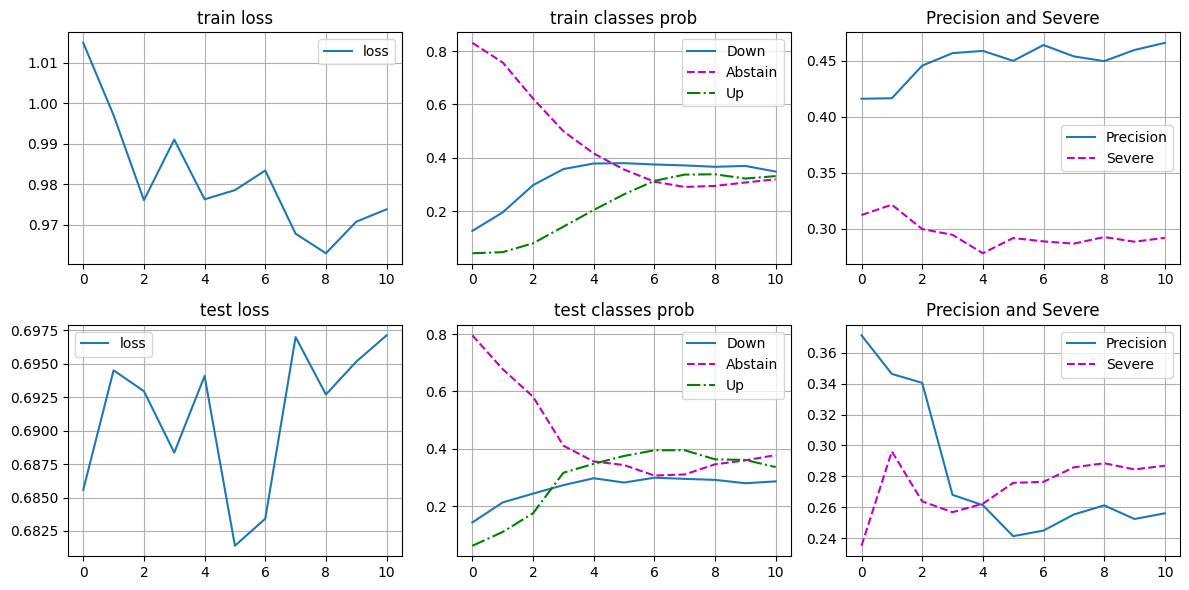

100%|██████████| 100/100 [00:00<00:00, 444.98it/s]


(np.float64(0.8345), np.float64(0.12929898142600355))

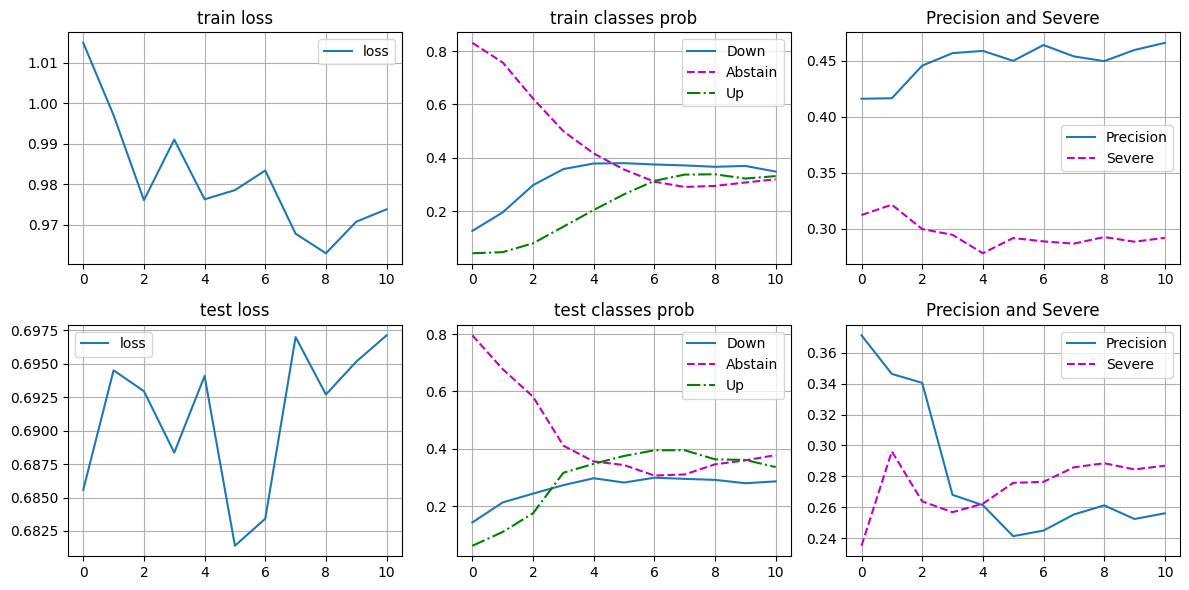

In [28]:
from utils.model_train import ModelTrain
train = ModelTrain(model = model,
                   batch_size = 100,
                   train_set = train_set,
                   validation_set=validation_set,
                   test_set=test_set,
                   loss_fn = loss_fn,
                   optimizer = optimizer,
                   scheduler=scheduler,
                   recorder=recorder,
                   graph=animator,
                   )
train.epoch_train(epochs = 10, round = 100, early_stop = 30)

In [29]:
print(BackTest(model, *train_set.all(),sliding_window=5,init_value=3000))
train.round(round = 100, is_train = False, use_set = 'train', print_summary = True)

yearly return :638.93%
std           :150.19%
sharpe ratio  :4.23


100%|██████████| 100/100 [00:00<00:00, 507.07it/s]


,Prediction Ratio,Precision: Right/Pred,Severe: Wrong/Pred,Real Ratio,Accuracy: Right/Real
negative,35.31%,51.01%,30.44%,36.92%,48.78%
neutral,32.67%,36.09%,0.00%,26.76%,44.06%
positive,32.02%,43.63%,30.07%,36.32%,38.46%
neg + pos,67.33%,47.50%,30.27%,73.24%,43.66%


In [30]:
print(BackTest(model, *validation_set.all(),sliding_window=5,init_value=3000))
train.round(round = 100, is_train = False, use_set = 'validation', print_summary = True)

yearly return :-108.74%
std           :115.10%
sharpe ratio  :-0.97


100%|██████████| 100/100 [00:00<00:00, 435.63it/s]


,Prediction Ratio,Precision: Right/Pred,Severe: Wrong/Pred,Real Ratio,Accuracy: Right/Real
negative,28.63%,35.45%,37.44%,27.30%,37.18%
neutral,37.49%,54.25%,0.00%,48.63%,41.83%
positive,33.88%,18.89%,20.51%,24.07%,26.59%
neg + pos,62.51%,26.48%,28.27%,51.37%,32.22%


In [31]:
print(BackTest(model, *test_set.all(),sliding_window=5,init_value=3000))
train.round(round = 100, is_train = False, use_set = 'test', print_summary = True)

yearly return :354.21%
std           :75.40%
sharpe ratio  :4.66


100%|██████████| 100/100 [00:00<00:00, 427.74it/s]


,Prediction Ratio,Precision: Right/Pred,Severe: Wrong/Pred,Real Ratio,Accuracy: Right/Real
negative,62.91%,52.55%,47.45%,46.44%,71.19%
neutral,16.36%,0.00%,0.00%,0.00%,0.00%
positive,20.73%,67.05%,32.95%,53.56%,25.95%
neg + pos,83.64%,56.15%,43.85%,100.00%,46.96%


In [32]:
# torch.save(model.state_dict(), 'params/baseline.params')